# Segmentacion de venas en la retina

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
import numpy as np
import random
import cv2
import os

Verificamos si tenemos GPU´s disponibles

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print("-----------------------------------------------------")
print("Los dispositivos encontrados son: ", gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPUs físicos,", len(logical_gpus), "GPUs lógicos")
    except RuntimeError as e:
        print(e)
print("----------------------------------------------------- \n")

-----------------------------------------------------
Los dispositivos encontrados son:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 GPUs físicos, 1 GPUs lógicos
----------------------------------------------------- 



## Preprocesamiento de los datos

Comenzamos indicando donde se encuentran los datos que estaremos usando para el entrenameinto y la validación

In [ ]:
#Directorios de entrenamient y validación
input_dir= "Base_Datos/Entrenamiento_Total/Img"
target_dir= "Base_Datos/Entrenamiento_Total/Mask"

val_input_it= "Base_Datos/Validacion_Total/Img"
val_target_it= "Base_Datos/Validacion_Total/Mask"

#Tamaño de las imagenes, batch de entrenamiento y validacion
img_size = (400, 400)
num_classes = 2
batch_size_t = 1
batch_size_v = 1

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir) 
        if fname.endswith(".png")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_input_paths = sorted(
    [
        os.path.join(val_input_it, fname)
        for fname in os.listdir(val_input_it)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_target_paths = sorted(
    [
        os.path.join(val_target_it, fname)
        for fname in os.listdir(val_target_it)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

ID_input_t= np.arange(len(input_img_paths))
ID_input_v= np.arange(len(val_input_paths))

In [ ]:
print(input_img_paths[0:5])

['Base_Datos/Entrenamiento_Total/Img\\im_0_0_1007.png', 'Base_Datos/Entrenamiento_Total/Img\\im_0_0_1011.png', 'Base_Datos/Entrenamiento_Total/Img\\im_0_0_1018.png', 'Base_Datos/Entrenamiento_Total/Img\\im_0_0_1021.png', 'Base_Datos/Entrenamiento_Total/Img\\im_0_0_1038.png']


Generador encargado de entregar los datos de entrenamiento y validación a la red neuronal

In [ ]:
#Generador de los ejemplos de entrada
class MiClasificacion(tf.keras.utils.Sequence):
    def __init__(self, input_img_paths, target_img_paths, ID_input, shuffle= True, batch_size= 32, img_size= (304, 304, 3), train= True):

        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.ID_input = ID_input
        self.shuffle= shuffle
        self.cont= 0
        self.train= train

    def __len__(self):
        # Calcula el número de pasos por época.
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):

        # Combinamos los datos en cada epoca, pero solo para los datos de entrenamiento
        if (self.cont== len(self.target_img_paths) // self.batch_size) or (self.cont== 0) and (self.train== True):
            np.random.shuffle(self.ID_input)
            self.cont= 0
            
        i = idx * self.batch_size
        batch_img= []
        batch_tar= []
        if self.train== True:
            self.cont =self.cont +1

        #De acuerdo a los indices en ID_input tomamos las imagenes de los paths correspondientes
        for ig in self.ID_input[i : i + self.batch_size]:
            batch_img.append(self.input_img_paths[ig])
            batch_tar.append(self.target_img_paths[ig])

        X, Y= self.__data_generation(batch_img, batch_tar)                                          # Mandamos llamar a la funcion generadora de los ejemplos

        return X, Y

    def __data_generation(self, biip, btip):
            
        # Creacion del tensor con dimensiones las dimensiones de entrada
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        #x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")                    # Generamos un tensor que almacenara las imagenes importadas     
        for j, path in enumerate(biip):
            img = load_img(path, target_size=self.img_size)                                         # Cragamos las imagenes de entrada 
            x[j] = np.array(img)/255.0                                                              # Normalizamos y agregamos la imagen al tensor

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")                      # Generamos un tensor que almacenara las mascaras importadas 
        for j, path in enumerate(btip):
            img = load_img(path,target_size= self.img_size,color_mode="grayscale")                  # Importamos la imagne en escala de grises
            y[j] = np.expand_dims(img, 2)
            for r in range(y.shape[1]):
                for g in range(y.shape[2]):
                    if y[j, r, g, 0]!= 0:                                                           # Nos aseguramos de que las venas etiquetadas resulten se un 1
                        y[j, r, g, 0]= 1

        return x, y

## Diseño del modelo U-NET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Definimos el modelo U-NET por partes

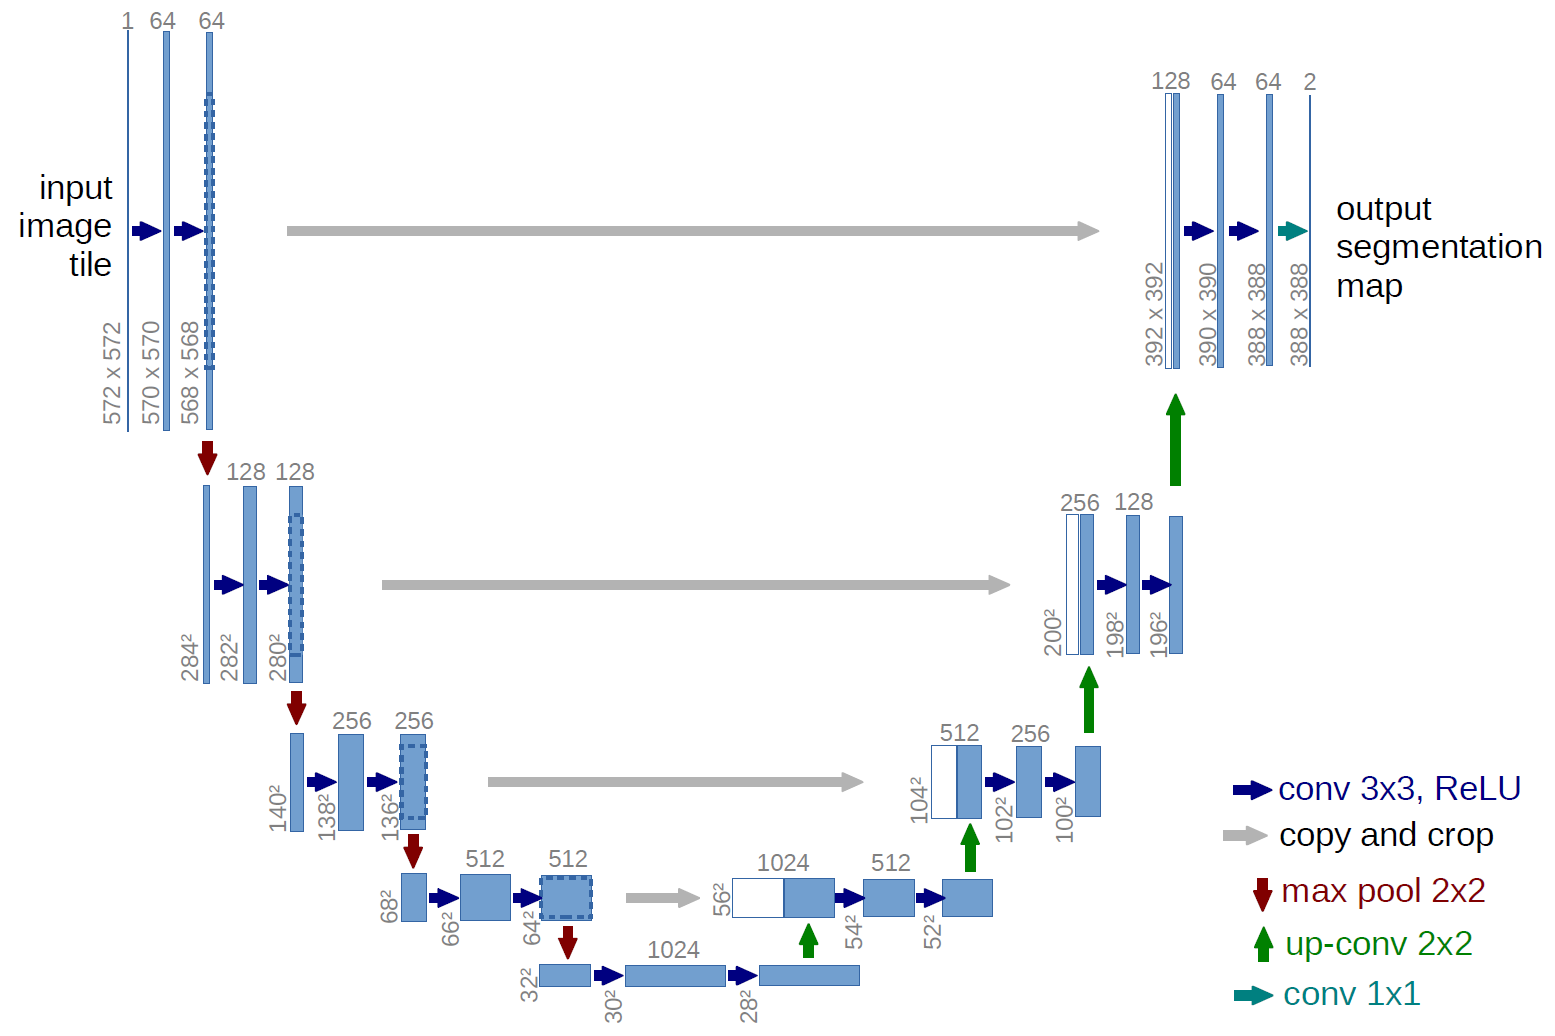

In [ ]:
# Generamos la secuencia del DownSampling de UNET
def conv_code(entrada, filtros, ker_reg= None):
    x= Conv2D(filtros, 3, padding= "same", activation= "relu",  kernel_regularizer= ker_reg)(entrada)
    x= BatchNormalization()(x)

    x= Conv2D(filtros, 3, padding= "same", activation= "relu", kernel_regularizer= ker_reg)(x)
    x= BatchNormalization()(x)

    residual= x
    x= MaxPooling2D(3, strides= 2, padding= "same")(x)
  
    return residual, x

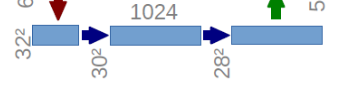

In [ ]:
# Generamos la secuencia BottleNeck correspondiente a l
def botle(entrada):
    x= Conv2D(512, 3, padding= "same", activation= "relu",  kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.001, l2=0.001))(entrada)
    x= BatchNormalization()(x)
    x= Conv2D(512, 3, padding= "same", activation= "relu",  kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.001, l2=0.001))(x)
    x= BatchNormalization()(x)

    x= Conv2DTranspose(256, 3,padding= "same" )(x)

    return x


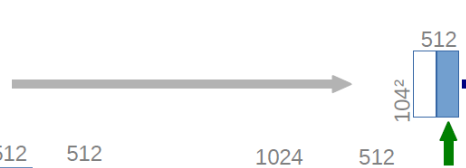

In [ ]:
# Para ir subiendo entre capa y capa
def crop_and_cat(entrada, res):
    x= UpSampling2D(2)(entrada)
    return concatenate([x, res])

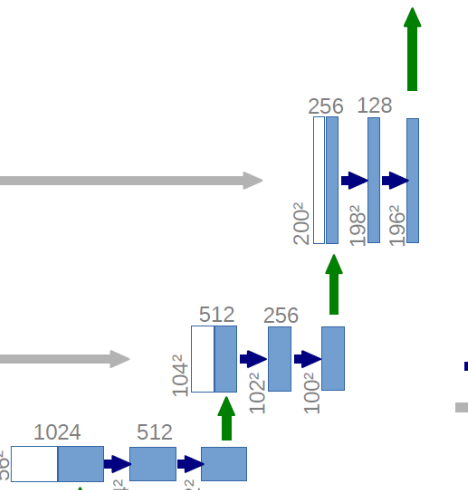

In [ ]:
# Generamos el UPSAMPLING 
def conv_decode(entrada, filtros, ker_reg= None):
    x= Conv2D(filtros, 3, padding= "same", activation= "relu", kernel_regularizer= ker_reg)(entrada)
    x= BatchNormalization()(x)
    x= Conv2D(filtros, 3, padding= "same", activation= "relu", kernel_regularizer= ker_reg)(x)
    x= BatchNormalization()(x)

    x= Conv2DTranspose(int(filtros/2), 3,padding= "same" )(x)

    return x

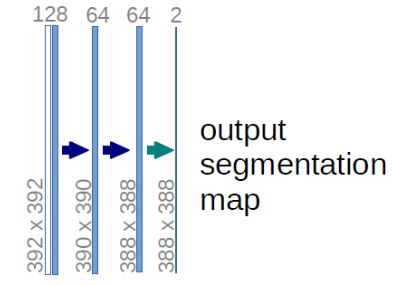

In [ ]:
#La capa final de salida
def capa_final(entrada, filtros, num_clases):
    x= Conv2D(filtros, 3, padding= "same", activation= "relu")(entrada)
    x= BatchNormalization()(x)

    x= Conv2D(filtros, 3, padding= "same", activation= "relu")(x)
    x= BatchNormalization()(x)

    x= Conv2D(num_clases, 3, padding= "same", activation= "softmax")(x)

    return x

## Generamos el modelo y lo regresamos al ser llamada

In [ ]:
#Generamos el modelo
def get_model(img_size, num_classes):
    inputs= tf.keras.Input(shape= img_size+ (3,))
  
    res_1, conv_1= conv_code(inputs, 64)
    res_2, conv_2= conv_code(conv_1, 128)
    res_3, conv_3= conv_code(conv_2, 256, tf.keras.regularizers.L1L2(l1=0.001, l2=0.001))

    bot= botle(conv_3)

    crop1= crop_and_cat(bot, res_3)
    decode_3= conv_decode(crop1, 256, tf.keras.regularizers.L1L2(l1=0.001, l2=0.001))

    crop2= crop_and_cat(decode_3, res_2)
    decode_2= conv_decode(crop2, 128)

    crop3= crop_and_cat(decode_2, res_1)
    x= Dropout(rate= 0.5)(crop3)
    outputs= capa_final(x, 64, 2)

    model= tf.keras.Model(inputs, outputs)
    return model

In [ ]:
# Funcion para comenzar el entrenamiento
def entrenamient_modelo(train_gen, val_gen, DIR_save, epocas= 30, visualizacion= False):

    #Generamos los callback necesarios
    checkpoint= ModelCheckpoint(DIR_save+ "14052021_400.hdf5", monitor= 'val_loss', save_best_only= True, mode= 'min', save_weights_only= False)
    reduceLROnPlat= ReduceLROnPlateau(monitor= 'val_loss', factor= 0.8, patience= 3, min_delta= 0.001, cooldown= 7, min_lr= 0.0001)
    tensorboard_callback = TensorBoard(log_dir= datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks= [EarlyStopping(patience= 12,  monitor='val_loss'), History(), checkpoint, reduceLROnPlat, tensorboard_callback]

    #Compilamos con la funcion perdida y el optimizador que utilizaremos
    model.compile(optimizer="SGD", loss= "sparse_categorical_crossentropy", metrics= ['accuracy']) #loss= "binary_crossentropy", metrics= ['accuracy'])
    history= model.fit(train_gen, epochs=epocas, validation_data=val_gen, callbacks=callbacks)

    # Mostramos las metricas durante el entrenamietno
    if visualizacion== True:
        plt.plot(history.history['loss'], label= "Loss ent")
        plt.plot(history.history['accuracy'], label= "Acc ent")
        plt.title("Metricas entrenamiento")
        plt.legend()
        plt.figure()

        plt.plot(history.history['val_loss'], label= "Loss val")
        plt.plot(history.history['val_accuracy'], label= "Acc val")
        plt.title("Metricas validación")
        plt.legend()
        plt.show()

In [ ]:
def infor_model(img_size):
    model = get_model(img_size, 2)           # Generamos el modelo con el tamaño de las imagenes de entrada y la salida esperada
    model.summary()  

def carga_mod(DIR):
    return tf.keras.models.load_model(DIR)

In [ ]:
#Creamos los generadoras para el entrenamiento y la validación
train_gen = MiClasificacion(
    input_img_paths, target_img_paths, ID_input_t, shuffle= True, batch_size= batch_size_t, img_size= img_size, train= True
)

val_gen = MiClasificacion(
    val_input_paths, val_target_paths, ID_input_v, shuffle= True, batch_size=batch_size_v, img_size= img_size, train= False
)

#Generamos un resumen del modelo generado
infor_model((400, 400))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#Generamos el modelo
model= get_model(img_size, 2)

#Direccion en donde se va a guardar el modelo
DIR_save_best= 'Base_Datos/'

#Comenzando con el entrenamiento
entrenamient_modelo(train_gen, val_gen, DIR_save_best, 20, True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7380 steps, validate for 100 steps
Epoch 1/20
 431/7380 [>.............................] - ETA: 28:34 - loss: 81.1051 - accuracy: 0.8834

KeyboardInterrupt: 

## Cargando y probando el modelo

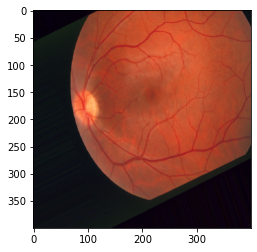

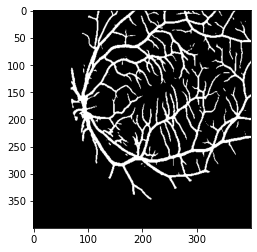

In [ ]:
import matplotlib.image as mpimg
from PIL import ImageOps
import PIL

t= "Base_Datos/Validacion_Total/Img/im_60_0_7687.png"
DIR= 'modelo_guardado.hdf5'

model= carga_mod(DIR)

img=mpimg.imread(t)
img= load_img(t, target_size=(400, 400, 3))

plt.imshow(img)
plt.show()
img= (np.array(img).reshape(-1,400,400,3))/255.0
val_preds = model.predict(img)
mask = np.argmax(val_preds[0], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
plt.imshow(img, cmap="gray")
plt.show()